In [1]:
!pip install tensorflow
!pip install keras
!pip install pythainlp
!pip install full
!pip install emoji
!pip install attacut
import tensorflow
from gensim.models import Word2Vec,KeyedVectors
from tqdm import tqdm
import pandas as pd
import numpy as np
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU, LSTM,Bidirectional, Embedding, Dropout,BatchNormalization
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import pythainlp
from pythainlp.corpus import thai_stopwords
from pythainlp.tokenize import word_tokenize
import re
import string
from pythainlp.util import normalize
from pythainlp.tokenize import newmm

2024-09-16 16:50:30.076775: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-16 16:50:31.750406: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
x_train = pd.read_csv('csv/x_train.csv',encoding='utf-8')
x_test = pd.read_csv('csv/x_test.csv',encoding='utf-8')
y_train = pd.read_csv('csv/y_train.csv',encoding='utf-8')
y_test = pd.read_csv('csv/y_test.csv',encoding='utf-8')

In [3]:
model = Word2Vec.load('model/w2v_model2.bin')

In [4]:
def cleanText(sentences):
    tokenized_sentences = []
    cleaned_sentences = []  # เพิ่มคอลัมน์เก็บประโยคที่ทำความสะอาดแล้ว
    
    for txt in sentences:
        # แปลงเป็น string
        t = str(txt)

        # ลบตัวอักษรที่ไม่ใช่ภาษาไทย
        cleaned_text = re.sub('[^ก-๙]', '', t)

        # Normalize ข้อความ (เช่น การปรับสระให้เป็นรูปแบบเดียวกัน)
        normalized_text = normalize(cleaned_text)

        # ดึง stopwords ภาษาไทย
        stop_words = set(thai_stopwords())

        # ตัดคำโดยใช้ engine "newmm" สำหรับการตัดคำภาษาไทย
        words = word_tokenize(normalized_text, engine="newmm")

        # ลบ stopwords และคำที่มีช่องว่าง
        filtered_words = [word for word in words if word not in stop_words and word.strip()]

        # แปลงเป็น lowercase
        tokenized_sentence = [word.lower() for word in filtered_words]

        # เก็บผลลัพธ์ของการตัดคำ
        tokenized_sentences.append(tokenized_sentence)

        # เก็บผลลัพธ์ของประโยคที่ทำความสะอาดแล้ว
        cleaned_sentence = " ".join(tokenized_sentence)
        cleaned_sentences.append(cleaned_sentence)

    return cleaned_sentences, tokenized_sentences  # คืนค่า 2 ค่า: ประโยคที่ทำความสะอาดแล้ว และการตัดคำ

In [5]:
!pip install imbalanced-learn

In [6]:
from imblearn.over_sampling import SMOTE

In [7]:
#smote = SMOTE(random_state=42)
#X_resampled, y_resampled = smote.fit_resample(x_train, y_train)

In [8]:
x_test['cleantext'], tokenized_sentences = cleanText(x_test['body'])
x_train['cleantext'], tokenized_sentences = cleanText(x_train['body'])

In [9]:
def get_average_vector(text):
    tokens = word_tokenize(text, engine="newmm")
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [10]:
X_train_vectors = [get_average_vector(text) for text in x_train['cleantext']]
X_test_vectors = [get_average_vector(text) for text in x_test['cleantext']]

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [12]:
def reduce_dimension_with_tsne(vectors, n_components=2, random_state=42):
    tsne = TSNE(n_components=n_components, random_state=random_state)
    vectors_array = np.array(vectors)
    return tsne.fit_transform(vectors_array)


In [13]:
X_train_tsne = reduce_dimension_with_tsne(X_train_vectors)
X_test_tsne = reduce_dimension_with_tsne(X_test_vectors)

In [14]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_tsne, y_train)

In [15]:
# ตรวจสอบขนาดของข้อมูล
print(len(X_resampled), len(y_resampled))

10820 10820


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [17]:
clf = LogisticRegression()
clf.fit(X_resampled, y_resampled)

/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [18]:
y_pred = clf.predict(X_test_tsne)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.17      0.68      0.27       412
           1       0.94      0.61      0.74      3580

    accuracy                           0.61      3992
   macro avg       0.56      0.65      0.50      3992
weighted avg       0.86      0.61      0.69      3992



In [19]:
from sklearn.ensemble import RandomForestClassifier

# ใช้ Random Forest เป็นโมเดล
RF = RandomForestClassifier(random_state=42)
RF.fit(X_resampled, y_resampled)

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

In [21]:
y_pred = RF.predict(X_test_tsne)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.28      0.39      0.32       412
           1       0.93      0.88      0.90      3580

    accuracy                           0.83      3992
   macro avg       0.60      0.64      0.61      3992
weighted avg       0.86      0.83      0.84      3992



/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel

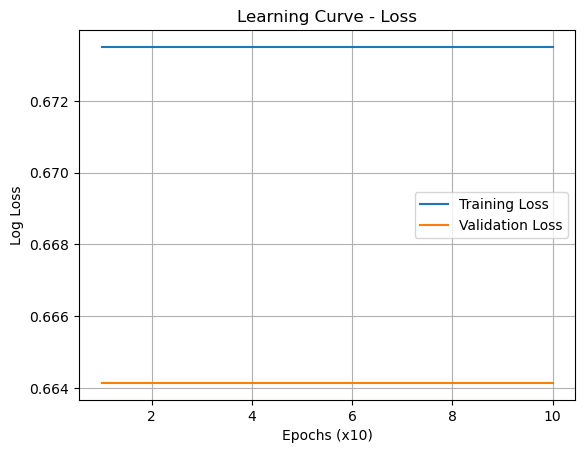

In [24]:
from sklearn.metrics import log_loss
train_losses = []
val_losses = []

for i in range(1, 11):
    clf.max_iter = 10 * i
    clf.fit(X_resampled, y_resampled)
    
    # คำนวณ loss บน training set และ validation set
    train_loss = log_loss(y_resampled, clf.predict_proba(X_resampled))
    val_loss = log_loss(y_test, clf.predict_proba(X_test_tsne))
    
    train_losses.append(train_loss)
    
    val_losses.append(val_loss)

# แสดงกราฟ
plt.plot(range(1, 11), train_losses, label='Training Loss')
plt.plot(range(1, 11), val_losses, label='Validation Loss')
plt.xlabel('Epochs (x10)')
plt.ylabel('Log Loss')
plt.title('Learning Curve - Loss')
plt.legend()
plt.grid()
plt.show()